In [3]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.compiler import transpile

# Qubit Reuse by Reset and Mid-Circuit Measurement

This transpiler pass is able to reduce the size of certain circuits by
rearranging the qubits and using resets and mid-circuit measurements to
reuse certain qubits.

In order to use this plugin you need to install it using:
```bash
pip install qiskit-qubit-reuse
```

To use it on the transpiler specify "qubit_reuse" (for smallest of both),
"qubit_reuse_normal" (for forward reduction,) or "qubit_reuse_dual" (for 
backwards or 'dual' reduction).

```py
from qiskit.circuit.random import random_circuit
from qiskit_aer import AerSimulator

qc = random_circuit(8, 3, measure=True)
backend = AerSimulator()
t_qc = transpile(qc, backend, optimization_level=3, init_method='qubit_reuse')
```

## Randomized circuit:
Let's try with a random 8 qubit circuit of depth 3. We can transpile this circuit to work with the AerSimulator.

We will compute both the reduced as well as the normal transpiled version of the circuit.

In [8]:
from qiskit.circuit.random import random_circuit
from qiskit_aer import AerSimulator

qc = random_circuit(16, 3, measure=True)
backend = AerSimulator()
t_qc = transpile(qc, backend, optimization_level=3, init_method='qubit_reuse')
t_qc_original = transpile(qc, backend, optimization_level=3) # For comparison later

/Users/raynelsanchez/Desktop/New Qubit Reuse/.venv/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/raynelsanchez/Desktop/New Qubit Reuse/.venv/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


See the original circuit:

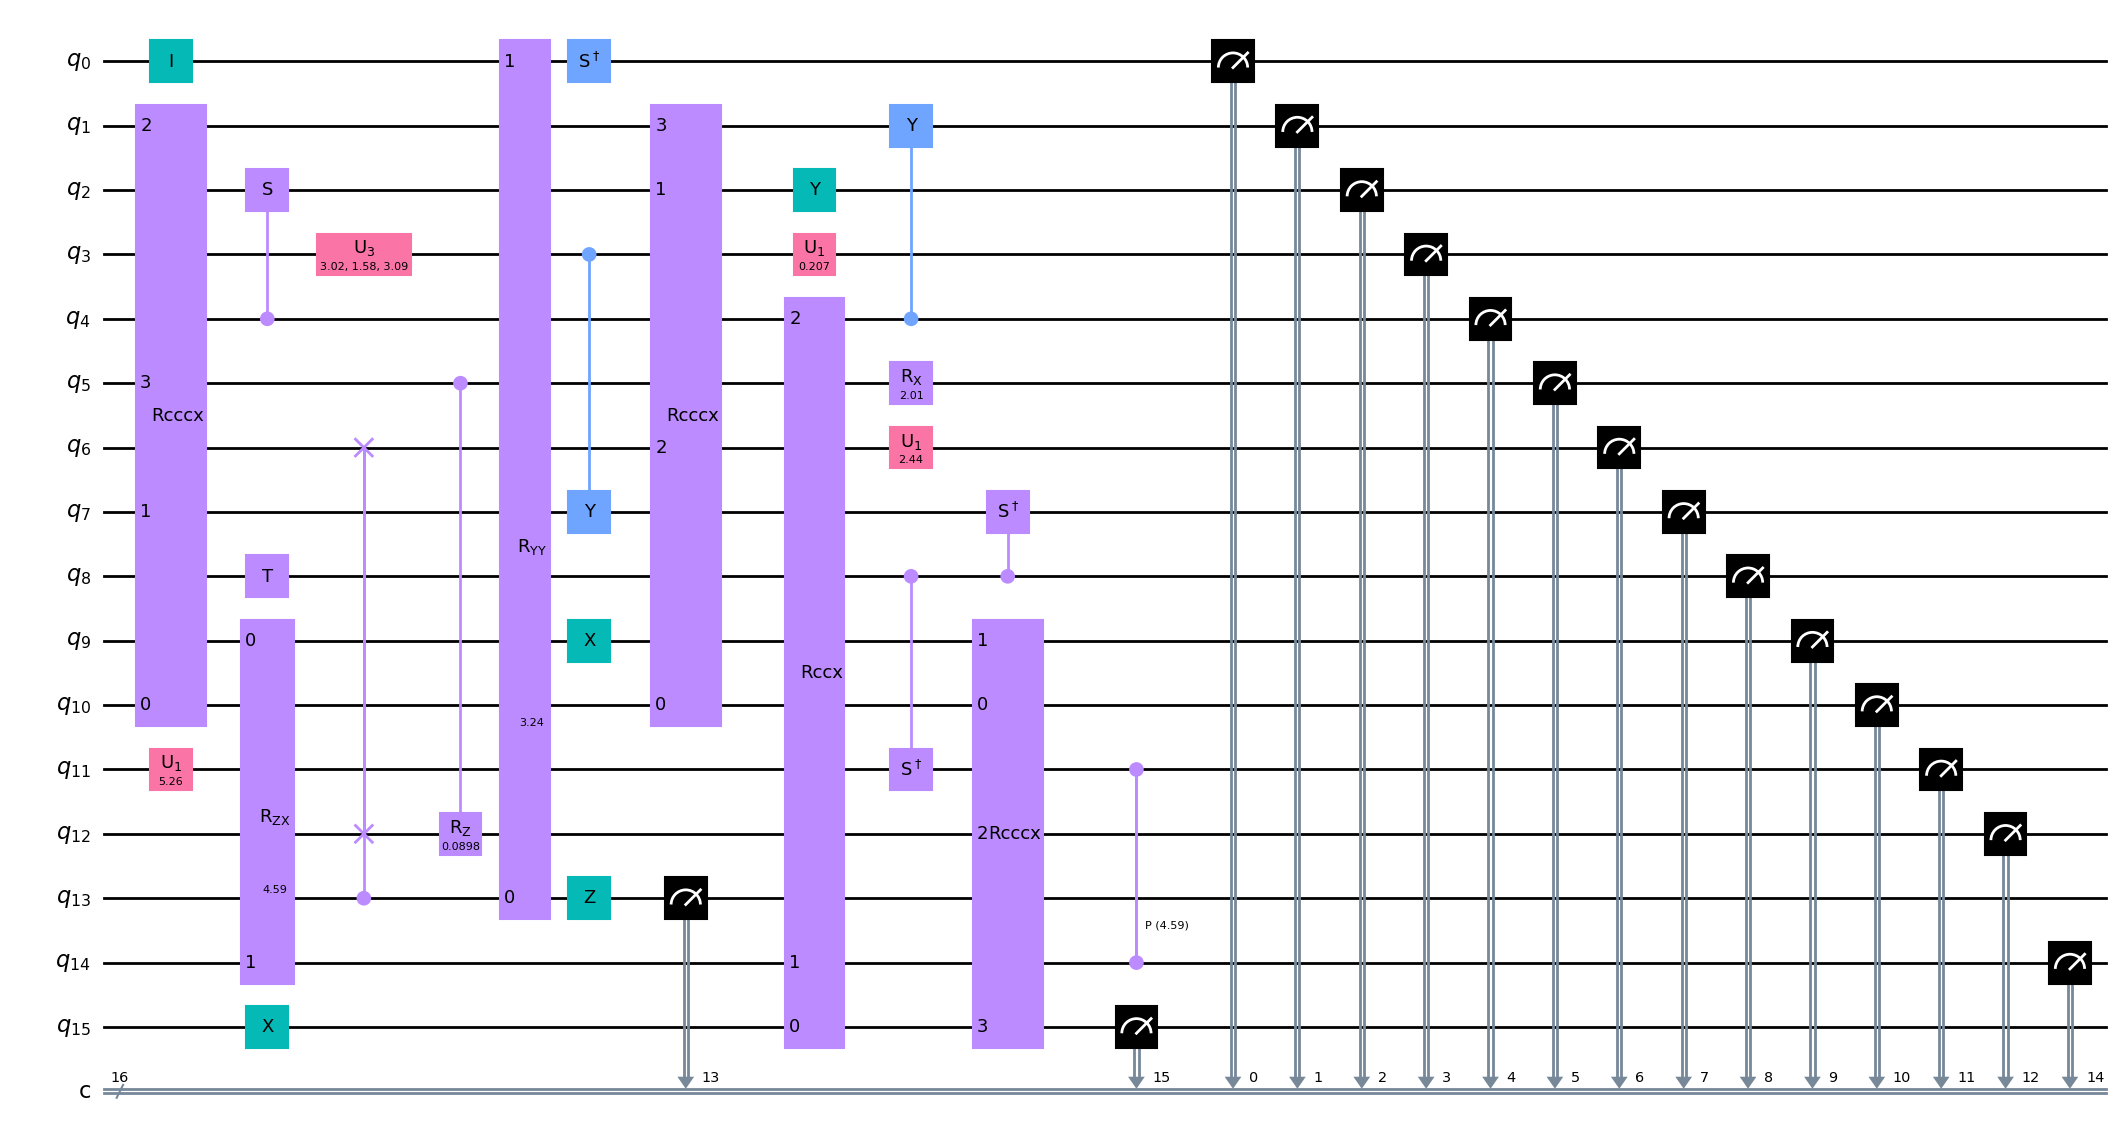

In [9]:
qc.draw('mpl', fold=-1)

And the reduced version:

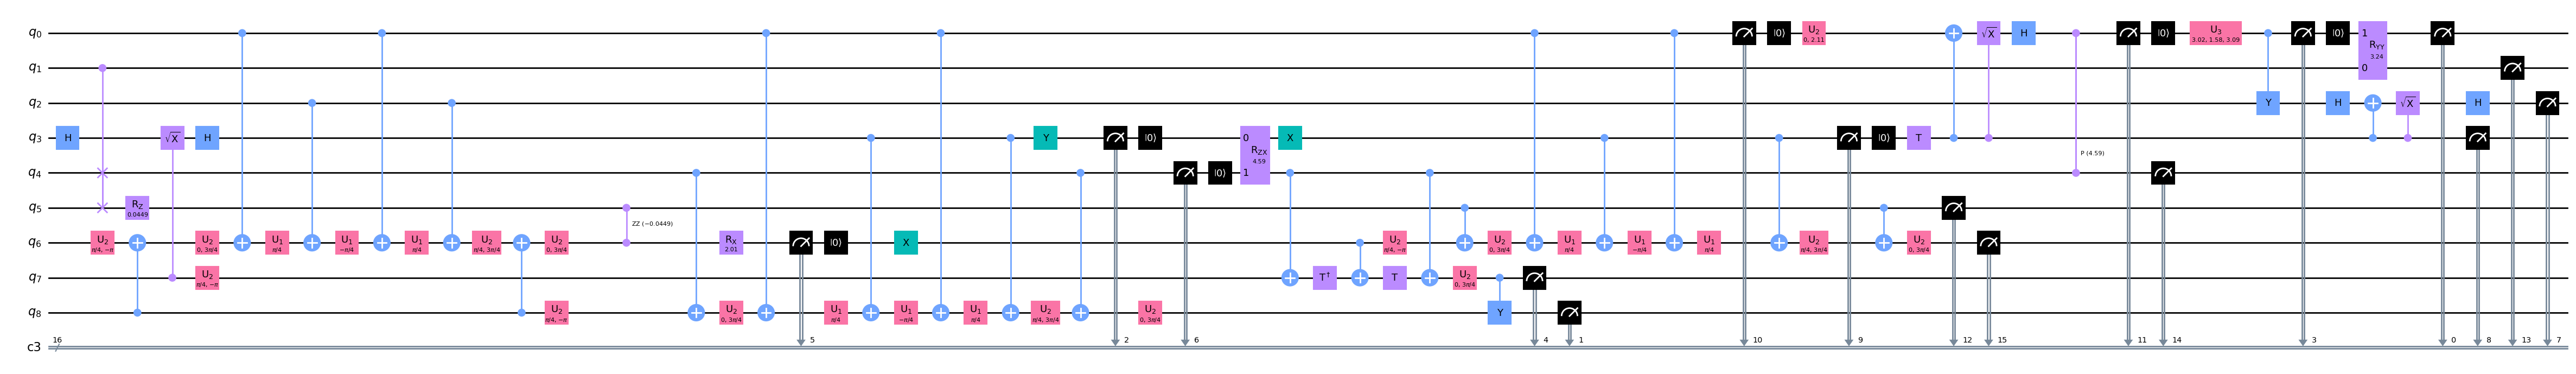

In [10]:
t_qc.draw('mpl', fold=-1)

### Comparison:
We will quickly run the circuits and use `hellinger_fidelity` to test if they're equivalent.

In [11]:
from qiskit.quantum_info import hellinger_fidelity

counts_normal = backend.run(t_qc_original, shots=2**12).result().get_counts()
counts_reduced = backend.run(t_qc, shots=2**12).result().get_counts()

hellinger_fidelity(counts_normal, counts_reduced)

0.9981834013947365

# Test with other Quantum Algorithms

## Bernstein-Vazirani

This algorithm can reduce an N size Bernstein Vazirani circuit into a size 2 circuit.

There's an increase in the depth of the circuit that grows linearly with the amount of qubits and their operations used in the original circuit.

In [12]:
def build_bv_circuit(secret_string):
    input_size = len(secret_string)
    num_qubits = input_size + 1
    qr = QuantumRegister(num_qubits)
    cr = ClassicalRegister(input_size)
    qc = QuantumCircuit(qr, cr, name="main")
    qc.x(qr[input_size])
    qc.h(qr)
    qc.barrier()
    for i_qubit in range(input_size):
        if secret_string[input_size - 1 - i_qubit] == "1":
            qc.cx(qr[i_qubit], qr[input_size])
    qc.barrier()
    qc.h(qr)
    qc.x(qr[input_size])
    qc.barrier()
    qc.measure(qr[:-1], cr)
    return qc

### Test:

We will use the secret state of 1949 the result for our Bernstein-Vazirani circuit.

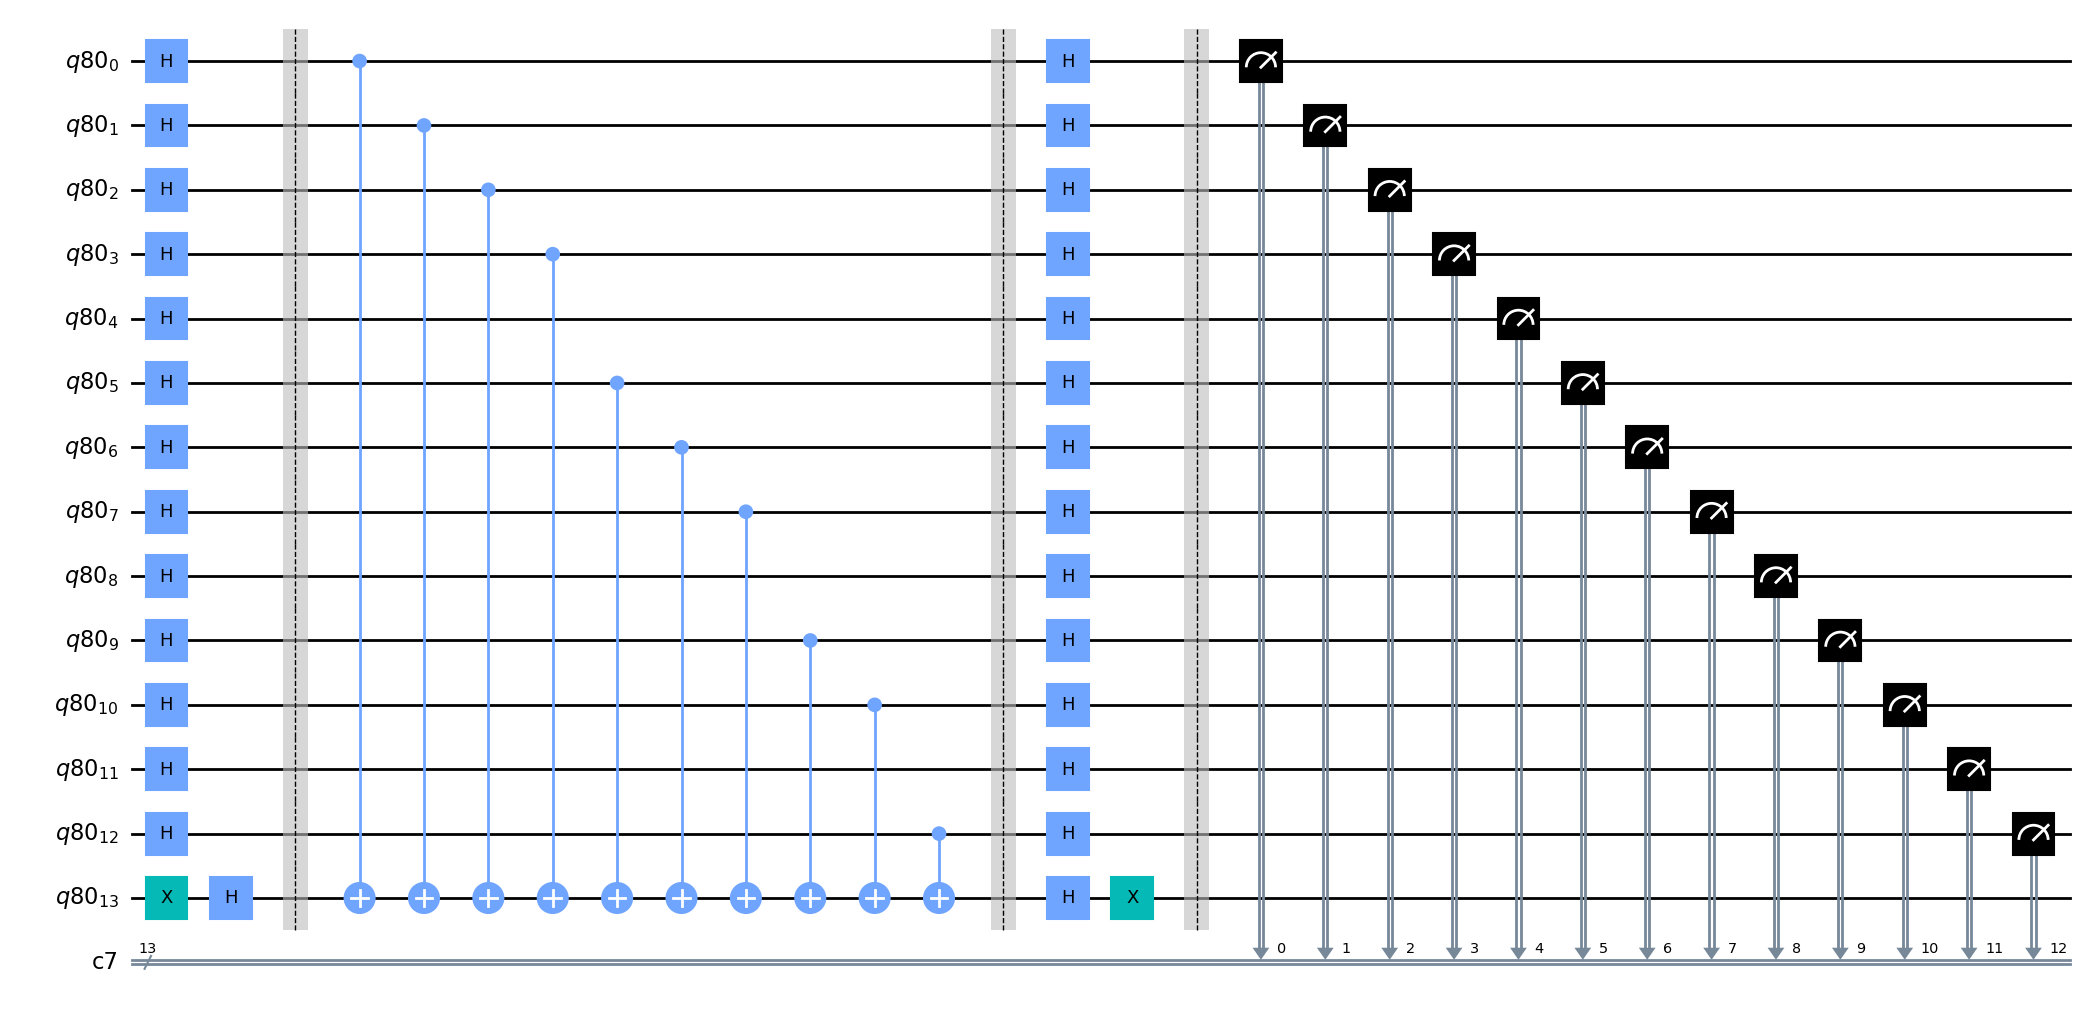

In [16]:
secret = 5871
secret_string = format(secret, f"0b")
qc = build_bv_circuit(secret_string=secret_string)
qc.draw('mpl', fold=-1)

We will now transpile the circuit with both the normal and reduced results.

In [17]:
t_qc = transpile(qc, backend, optimization_level=3, init_method='qubit_reuse')
t_qc_original = transpile(qc, backend, optimization_level=3) # For comparison later

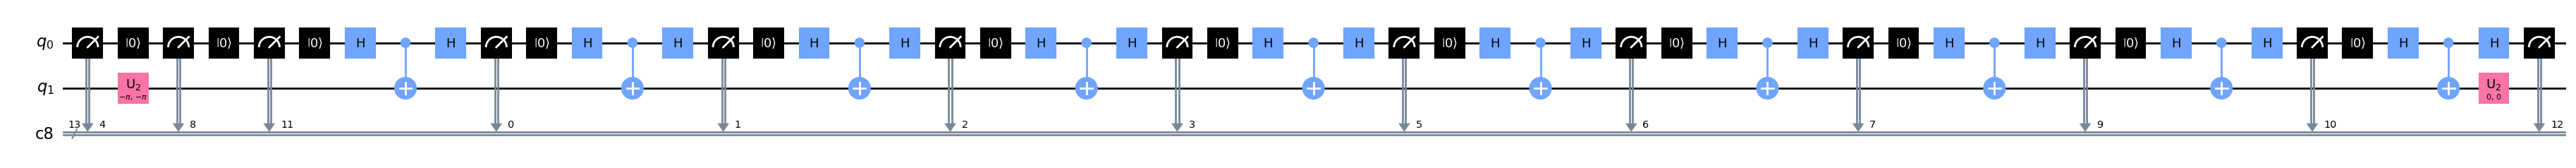

In [18]:
t_qc.draw('mpl', fold=-1)

### Results:
When running both the original and the reduced circuits, we still get the same result.

In [19]:
counts_normal = backend.run(t_qc_original, shots=2**12).result().get_counts()
counts_reduced = backend.run(t_qc, shots=2**12).result().get_counts()

print(counts_normal, counts_reduced)
hellinger_fidelity(counts_normal, counts_reduced)

{'1011011101111': 4096} {'1011011101111': 4096}


1.0

## Tree Tensor Network
This transpiler pass can reduce a 2^N qubit TTN circuit into an N+1 qubit sized circuit.

Let's try to generate an arbitrary 8 qubit Tree Tensor Network

_Generator functions courtesy of Gopal Ramesh Dahale_

_Source: https://medium.com/qiskit/exploring-tensor-network-circuits-with-qiskit-235a057c1287_

In [20]:
# Matrix Product State generator
from qiskit.circuit.library import RealAmplitudes

def MPS(num_qubits, **kwargs):
    """
    Constructs a Matrix Product State (MPS) quantum circuit.

    Args:
        num_qubits (int): The number of qubits in the circuit.
        **kwargs: Additional keyword arguments to be passed to the 
        RealAmplitudes.

    Returns:
        QuantumCircuit: The constructed MPS quantum circuit.
        
    """
    qc = QuantumCircuit(num_qubits)
    qubits = range(num_qubits)

    print(len(list(zip(qubits[:-1], qubits[1:]))))
    # Iterate over adjacent qubit pairs
    for i, j in zip(qubits[:-1], qubits[1:]):
        qc.compose(RealAmplitudes(num_qubits=2,
                                  parameter_prefix=f'θ_{i},{j}',
                                  **kwargs), [i, j],
                   inplace=True)
        qc.barrier(
        )  # Add a barrier after each block for clarity and separation

    return qc

In [21]:
# Tree tuples generator
def _generate_tree_tuples(n):
    """
    Generate a list of tuples representing the tree structure 
    of consecutive numbers up to n.

    Args:
        n (int): The number up to which the tuples are generated.

    Returns:
        list: A list of tuples representing the tree structure.
    """
    tuples_list = []
    indices = []

    # Generate initial tuples with consecutive numbers up to n
    for i in range(0, n, 2):
        tuples_list.append((i, i + 1))

    indices += [tuples_list]

    # Perform iterations until we reach a single tuple
    while len(tuples_list) > 1:
        new_tuples = []

        # Generate new tuples by combining adjacent larger numbers
        for i in range(0, len(tuples_list), 2):
            new_tuples.append((tuples_list[i][1], tuples_list[i + 1][1]))

        tuples_list = new_tuples
        indices += [tuples_list]

    return indices

In [22]:
# Tree Tensor Network Generator
def TTN(num_qubits, **kwargs):
    """
    Constructs a Tree Tensor Network (TTN) quantum circuit.

    Args:
        num_qubits (int): The number of qubits in the circuit.
        **kwargs: Additional keyword arguments to be passed to the 
        RealAmplitudes.

    Returns:
        QuantumCircuit: The constructed TTN quantum circuit.

    Raises:
        AssertionError: If the number of qubits is not a power of 2 
        or zero.
    """
    qc = QuantumCircuit(num_qubits)
    qubits = range(num_qubits)

    # Compute qubit indices
    assert num_qubits & (
        num_qubits -
        1) == 0 and num_qubits != 0, "Number of qubits must be a power of 2"

    indices = _generate_tree_tuples(num_qubits)

    # Iterate over each layer of TTN indices
    for layer_indices in indices:
        for i, j in layer_indices:
            qc.compose(RealAmplitudes(num_qubits=2,
                                      parameter_prefix=f'θ_{i},{j}',
                                      **kwargs), [i, j],
                       inplace=True)
        qc.barrier(
        )  # Add a barrier after each layer for clarity and separation

    return qc

### Test:
For this test we will generate an 8 qubit Tree Tensor network with parameters, that are between pi/8 and pi/2

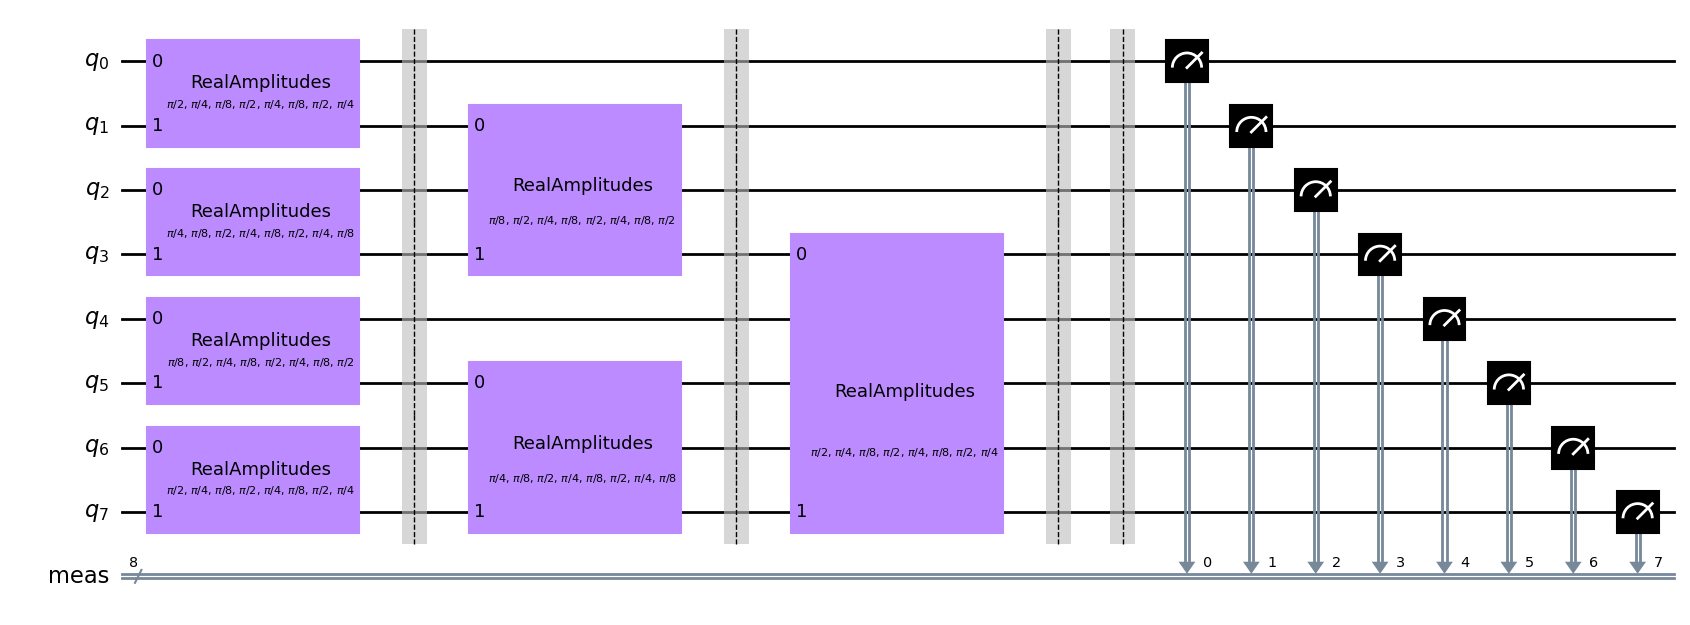

In [23]:
import numpy as np

qc = TTN(2**3)
qc.measure_all()
params = {param: np.pi/(2**((index%3)+1)) for index, param in enumerate(qc.parameters)}
qc = qc.bind_parameters(params)

qc.draw('mpl', fold=-1)

We will now transpile the circuit with both the normal and reduced results.

In [24]:
t_qc = transpile(qc, backend, optimization_level=3, init_method='qubit_reuse')
t_qc_original = transpile(qc, backend, optimization_level=3) # For comparison later

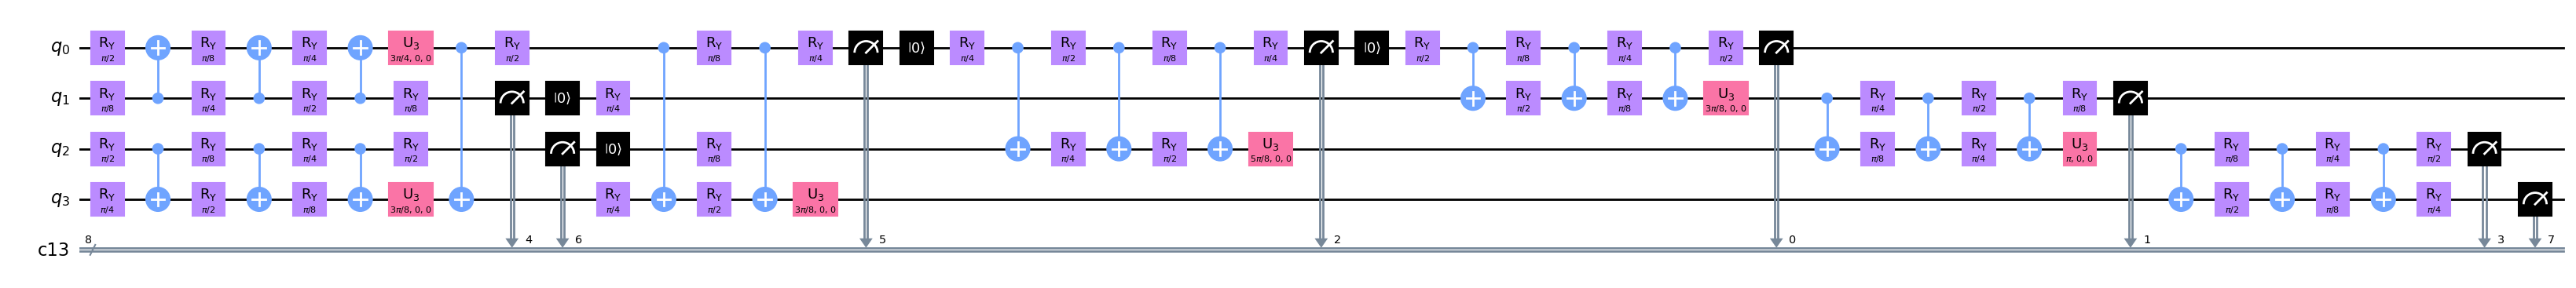

In [25]:
t_qc = transpile(qc, backend, optimization_level=3, init_method='qubit_reuse')
t_qc_original = transpile(qc, backend, optimization_level=3) # For comparison later
t_qc.draw('mpl', fold=-1)


### Results:
When running both the original and the reduced circuits, we get very similar results.


In [26]:
counts_normal = backend.run(t_qc_original, shots=2**12).result().get_counts()
counts_reduced = backend.run(t_qc, shots=2**12).result().get_counts()

# print(counts_normal, counts_reduced)
hellinger_fidelity(counts_normal, counts_reduced)

0.9743149826932695